
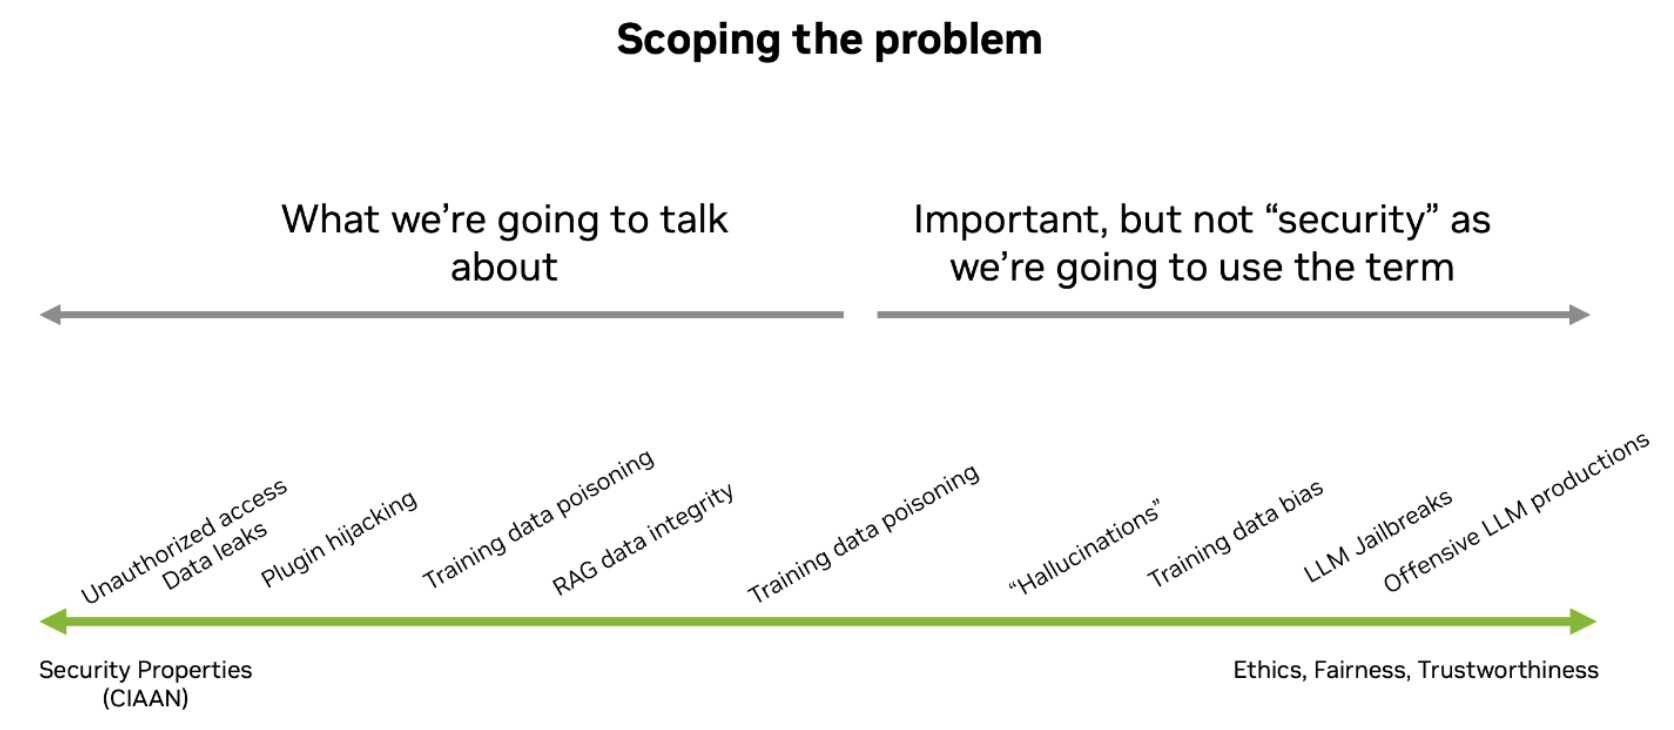


Source: [Nvidia - 2024 BlackHat presentation](https://i.blackhat.com/BH-US-24/Presentations/US24-Harang-Practical-LLM-Security-Takeaways-From-Wednesday.pdf)

### Remember LLMs themselves do nothing but predict the probability of the next “token” (sub-word pieces).

## Jailbreaking
Jailbreaking (making a model disobey its system prompt/guardrails) is a RAI issue rather than a security issue (unless examined
very closely). However, context is important as it could potentially impact agentic workflows where the output is used in
automated processes.

---

## LLM-specific Security Attacks & Mitigations

| Attack Name                      | Description                                                                                                                | Mitigation Strategies                                                                                                                                                               |
|----------------------------------|----------------------------------------------------------------------------------------------------------------------------|-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| **Training Data Poisoning**      | Injecting bias, malicious behavior, or vulnerabilities into models through manipulated training or fine-tuning data.       | Validate and sanitize training data.<br>Implement Role-Based Access Control (RBAC).<br>Conduct regular threat modeling and dataset security reviews.                                |
| **Model Serialization Attacks**  | Exploiting insecure serialization/deserialization (e.g., pickle) to execute arbitrary code upon model loading.             | Use secure serialization formats (e.g., SafeTensors).<br>Scan code for insecure deserialization methods using tools like semgrep ([AWS Reference](https://aws.amazon.com/blogs/security/enhancing-cloud-security-in-ai-ml-the-little-pickle-story/)). |
| **Malicious Model Layers**       | Embedding malicious or exploitable code in custom model layers that execute during inference.                              | Scan and audit model source code prior to deployment.<br>Use secure serialization formats and trusted libraries.                                                                    |
| **Training Data Inference**      | Determining if a specific data sample was used during model training by querying its output probabilities.                 | Minimize detailed model outputs (probabilities or logits).<br>Rate-limit user queries.<br>Monitor for repeated identical queries.                                                   |
| **Model Inversion Attacks**      | Reconstructing sensitive training data by analyzing repeated model outputs.                                                 | Limit detailed output probabilities or logits.<br>Block repeated token requests.<br>Monitor and alert on repeated identical queries.                                                |
| **Membership Inference Attacks** | Determining whether a particular data record was part of the training dataset.                                              | Apply Differential Privacy techniques ([Reference 1](https://arxiv.org/pdf/1806.01246v2), [Reference 2](https://arxiv.org/pdf/1802.04889v1)).<br>Reduce granularity of model outputs. |
| **Model Weight Extraction**      | Precisely extracting model weights (e.g., embeddings) by systematically querying model outputs.                             | Minimize exposure of token probabilities/logits.<br>Implement query rate-limiting.<br>Monitor unusual query patterns indicative of extraction attempts.                             |
| **Model Distillation (Extraction)**| Using detailed outputs (tokens and probabilities) from your model to efficiently replicate proprietary models.               | Avoid returning detailed per-token logits/probabilities.<br>Rate-limit queries.<br>Monitor and block repetitive or suspicious querying patterns.                                    |
| **Self-Instruct Data Generation**| Exploiting model capabilities to generate instruction-tuning datasets without authorization.                                | Restrict open-ended or detailed outputs.<br>Apply strict rate limiting.<br>Monitor for unusual query patterns indicative of unauthorized dataset generation.                         |
| **Excessive Agency**             | Allowing models excessive external interactions or actions, potentially leading to unintended harmful consequences.          | Limit external tool interaction.<br>Implement least-privilege access principles.<br>Ensure strict authorization checks in downstream systems.                                        |

### General Recommendations:
- Regularly monitor and audit LLM interactions for suspicious activity.
- Establish clear governance, risk, and compliance (GRC) frameworks for LLM use cases.
- Conduct continuous security training and threat modeling for engineering and data teams.
- Utilize automated monitoring to quickly detect emerging threats or abnormal usage patterns.


---

## Guardrails

Guardrails are defensive mechanisms placed around models to moderate output, manage conversations, and enforce output constraints. However, their effectiveness varies depending on their implementation, purpose, and robustness.

### General Characteristics

- Guardrails are best suited for **content moderation**, conversational guidance, and managing interactions with well-intentioned users.
- They are generally **not sufficient alone** to fully secure sensitive data or fully prevent malicious behavior.

### Limitations and Weaknesses

- Typical guardrails can often be bypassed using encoding or obfuscation techniques, such as:
    - Base64 encoding
    - Unicode or emoji substitutions
    - Multilingual text transformations

- **Reasoning Capability Gap**:
    - Even when addressing multilingual limitations, a critical challenge remains: guardrails often utilize smaller NLP models or rule-based systems. This creates a reasoning capability gap relative to powerful target LLMs, which attackers may exploit.
    - Closing this gap is challenging, so guardrails should never be the sole line of defense.

### Strategies for Enhanced Guardrails

To improve effectiveness, adopt a **defense-in-depth approach** by combining multiple strategies, including:

- **Refusal Classifiers**:
    - Use specialized classifiers trained to detect and refuse queries or responses containing sensitive or inappropriate content.
  
- **Domain-Specific Languages (DSL)**:
    - Employ rule-based systems specifically designed to identify, block, or filter content based on well-defined rules or patterns.

- **Real-Time Monitoring and Intervention**:
    - Continuously monitor interactions, detect unusual patterns or attempts at bypass, and intervene promptly.

### Blocking vs. Data Control

- Blocking specific responses or queries outright (e.g., blacklisting sensitive documents) is inherently imperfect and can be bypassed (leaky strategy).
- A more robust approach is proactive control:
    - Carefully control training data and Retrieval-Augmented Generation (RAG) inputs.
    - Prevent sensitive data exposure to the model in the first place.

### Format Validators as Robust Guardrails

#### What is a Format Validator?

- Format validators enforce output adherence to predefined structures or syntax (e.g., SQL, JSON, XML).
- They represent an advanced, robust form of guardrail compared to simple content moderation.

#### Comparison with Content Moderation:

| Aspect               | Content Moderation Guardrails                    | Format Validators                         |
|----------------------|--------------------------------------------------|-------------------------------------------|
| **Functionality**    | Filters inappropriate or unwanted textual content. | Enforces strict adherence to a specific structural format or syntax. |
| **Robustness**       | Easier to bypass via encoding or obfuscation.    | Difficult or nearly impossible to bypass through encoding alone.     |
| **Scope of Security**| Limited security against structural or encoding attacks. | Stronger security against structural attacks; ensures structural correctness. |

#### Can Format Validators be Bypassed?

- A well-implemented format validator (e.g., SQL validator):
    - Checks for exact structural and syntactical correctness.
    - Makes bypassing through encoding techniques (e.g., Base64 or emoji) extremely difficult or impractical because encoding invalidates required syntax.
    - However, while enforcing structure and syntax, it **does not inherently guarantee safety or security**. For example, syntactically valid SQL may still contain SQL injection vulnerabilities.

### Important Additional Considerations:

- Format validators are specialized and limited to their intended output format (SQL, JSON, XML, etc.).
- They cannot inherently prevent sensitive data leakage if the output is structurally correct.
- Format validators are an essential part of a broader security strategy, especially where structured or validated output is critical, but should always be supplemented by additional security layers.

**Never rely solely on guardrails to secure sensitive model interactions.**

---

## Attacks & Vulnerabilities Seen in Practice

### Context Window Overflow

**Description:**  
Exceeding the model's context window limit forces the model to lose track of earlier parts of the conversation. Attackers can exploit this to induce unintended model behaviors, such as generating toxic responses, leaking sensitive information, or executing misleading instructions.

**Mitigation Strategies:**  
- Validate and sanitize input length before passing it to the model.
- Automatically truncate or reject inputs exceeding context window limits.

**Further Reading:**  
- [AWS Security Blog: Context Window Overflow: Breaking the Barrier](https://aws.amazon.com/blogs/security/context-window-overflow-breaking-the-barrier/)

---

### Vulnerabilities in Plugins and Agents

Plugins and agents extend AI system functionalities but introduce distinct types of security vulnerabilities:

### 1. Plugins

**Description:**  
Plugins are modular, predefined extensions integrated with AI systems to perform specific tasks or interactions. Typically, plugins have a rigid structure with limited functionality.

**Examples of plugin tasks include:**  
- Fetching weather information  
- Language translation services  
- Database querying or API integration

**Common Plugin Vulnerabilities:**  
- **Remote code execution** due to unsafe functions like `eval()`.  
- **Server-side request forgery (SSRF)** from unvalidated or unparameterized URLs or requests.  
- **SQL injection attacks** resulting from improper parameterization.  
- **Cross-site scripting (XSS)** due to unescaped HTML output.  
- **Session data leakage** through improper markdown or output rendering.

**Mitigation Strategies:**  
- Always sanitize and validate plugin input/output.  
- Avoid unsafe functions (`eval`, raw queries, etc.).  
- Enforce strict parameterization for external requests or database interactions.  
- Properly escape or sanitize HTML and markdown content.

---

### 2. Agents

**Description:**  
Agents are more autonomous components within AI systems, capable of dynamically interacting with external resources, making decisions, and performing actions based on changing contexts. They typically leverage multiple plugins or tools simultaneously.

**Key differences from plugins:**  
- Higher autonomy and decision-making capability.  
- Dynamic interaction with external systems and multiple resources.  
- Greater operational flexibility and adaptability.

**Common Agent Vulnerabilities:**  
- **Excessive Agency:** Unintended or malicious interactions with external systems, potentially causing unauthorized actions or harmful outcomes.  
- **Software Supply Chain Vulnerabilities:** Issues arising from third-party libraries or dependencies, such as vulnerabilities seen in frameworks like [LangChain](https://developer.nvidia.com/blog/securing-llm-systems-against-prompt-injection/).

**Mitigation Strategies:**  
- Enforce the principle of least privilege—limit agents’ interactions and permissions strictly to required actions.  
- Implement rigorous validation and authorization checks for external interactions.  
- Regularly scan and review dependencies for known vulnerabilities and patch promptly.  
- Actively monitor and audit agent actions to detect anomalous behaviors.

**Further Reading:**  
- [Securing LLM Systems Against Prompt Injection (NVIDIA Blog)](https://developer.nvidia.com/blog/securing-llm-systems-against-prompt-injection/)

---

## Actionable Advice

### Security Boundaries: Traditional Principles Still Apply

- **Clearly define and analyze security boundaries**:  
  Understand where trust boundaries lie within your system.

- **Trace data flows thoroughly**:  
  Identify all entry and exit points for data within the application, especially data coming from or going to external or untrusted sources.

- **Apply the principle of least privilege**:  
  Restrict permissions and minimize privileges for all components, particularly plugins and agents. Limit the information included in outputs (error messages, intermediate results, logs).

---

### New Considerations for LLM-Based Applications

- **Anticipate Model Failure**:  
  LLMs are inherently unreliable—design application logic to gracefully handle unexpected or incorrect outputs.

- **Assume Adversarial Control of LLM Output**:  
  Treat outputs from LLMs as untrusted input that could be intentionally manipulated. Maintain strict tracking and validation of this potentially tainted data.

- **External Data is Application Input**:  
  Recognize that external data (including LLM outputs, third-party data, and user-provided data) can become attack vectors. Identify clearly who (or what) else can feed input into your application.

- **Design for Zero Trust with LLM Outputs**:  
  Always validate, sanitize, and constrain outputs from LLMs before consumption by downstream processes or users.

- **Isolate Sensitive Data from LLM Exposure**:  
  Do not depend on prompts or model behavior to keep sensitive information secure or confidential. Expect prompts or internal details to leak or become compromised.

---

### Proactively Detect and Mitigate Data Leakage

Regularly check for potential data leaks, paying special attention to:

- **Logging and Auditing**:
  - Monitor logs of external service calls by plugins and agents.
  - Track and audit precisely what information is sent externally.

- **Overprivileged Components**:
  - Identify and correct plugins or agents that have excessive permissions, especially those capable of arbitrary external requests (`eval()`, markdown rendering, unrestricted API access).

- **Guardrail Failures**:
  - Regularly review logs for guardrail rejections or anomalies indicating attempted bypass.

- **Response Caching and Storage**:
  - Monitor response caching mechanisms to prevent unintended leakage of sensitive data.

---

### Deploying Guardrails as Part of Comprehensive Security

Guardrails should always be part of a broader, holistic security strategy. Key components of an effective security framework include:

- **Training Data Controls and Sanitization**:
  Ensure high-quality, secure data inputs during training and fine-tuning processes.

- **Refusal Classifiers and Domain-specific Rules**:
  Proactively refuse potentially harmful or sensitive queries and outputs using specialized classifiers or defined business rules.

- **Real-time Monitoring and Human-in-the-loop Interventions**:
  Implement real-time monitoring solutions to quickly detect abnormal activities or security incidents. Incorporate human oversight for critical or ambiguous decisions.

- **Strong Access Controls and Limited Data Exposure**:
  Implement strict access controls, and limit data access to the absolute minimum required.

- **Strategic Partnerships and Collaborative Threat Modeling**:
  Work closely with internal and external stakeholders (e.g., data science teams, security groups) for ongoing threat modeling, best-practice sharing, and vulnerability mitigation.


## References
* [AI Model Security: Understanding Risks vs. Unfounded Concerns](https://www.linkedin.com/pulse/ai-model-security-understanding-risks-vs-unfounded-matthew-schwartz-6q34e/?trackingId=Kw%2B%2FHAtORP%2BMUbDIR9FDZw%3D%3D)
* [NVIDIA AI Red Team: An Introduction](https://developer.nvidia.com/blog/nvidia-ai-red-team-an-introduction/)
* [Microsoft: Threat Modeling AI/ML Systems and Dependencies](https://learn.microsoft.com/en-us/security/engineering/threat-modeling-aiml?source=recommendations)
* [MITRE ATLAS](https://atlas.mitre.org/matrices/ATLAS)
* [OWASP AI Security Project](https://owasp.org/www-project-ai-security/)
* [OWASP Top 10 for Large Language Model Applications](https://owasp.org/www-project-top-10-for-large-language-model-applications/)
* [AI Security and Safety Taxonomy](https://www.robustintelligence.com/ai-security-and-safety-taxonomy)
* [NIST AI Risk Management Framework](https://www.nist.gov/itl/ai-risk-management-framework)
* [Awesome MLSecOps](https://awesomemlsecops.com/)